# Topology Analysis

## Based on images processing  
**Datasets:**  
Labeled Faces in the Wild: http://vis-www.cs.umass.edu/lfw/

**Authors:**  
Gvozdeva V   
Kharchevnikova A   
Sokolova A

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
!tar -zxvf '/content/gdrive/My Drive/Faces/lfw.tgz'

In [0]:
# Preprocessing
import pathlib

dataset_path = pathlib.Path('/content/lfw/')
def get_all_imgs():
  all_imgs = list(dataset_path.rglob('*.jpg'))
  all_imgs.extend(dataset_path.rglob('*.png'))
  return all_imgs

def get_all_imgs_gen():
  return dataset_path.rglob('*.jpg')

def get_labels(imgs):
  labels = []
  for img in imgs:
    name = img.parts[3]
    labels.append(name)
  return labels

In [0]:
all_imgs = get_all_imgs()
labels = get_labels(all_imgs)

### Extract feature vectors

In [0]:
import tensorflow as tf
import argparse
import sys
import math
import datetime, time
import numpy as np
from sklearn import preprocessing, model_selection

from scipy import misc
from sklearn.pipeline import Pipeline
from PIL import Image

np.random.seed(123)  # for reproducibility

img_extensions=['.jpg','.jpeg','.png']
def is_image(path):
    _, file_extension = os.path.splitext(path)
    return file_extension.lower() in img_extensions

def get_files(db_dir):
    return [[d,os.path.join(d,f)] for d in next(os.walk(db_dir))[1] 
            for f in next(os.walk(os.path.join(db_dir,d)))[2] if is_image(f)]

def load_graph(frozen_graph_filename, prefix=''):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name=prefix)
    return graph

class TensorFlowInference:
    def __init__(self, frozen_graph_filename, input_tensor, output_tensor, learning_phase_tensor=None, convert2BGR=True,
                 imageNetUtilsMean=True, additional_input_value=0):
        graph = load_graph(frozen_graph_filename, '')
        print([n.name for n in graph.as_graph_def().node if 'input' in n.name])

        graph_op_list = list(graph.get_operations())
        print([n.name for n in graph_op_list if 'keras_learning' in n.name])

        self.tf_sess = tf.Session(graph=graph)

        self.tf_input_image = graph.get_tensor_by_name(input_tensor)
        print('tf_input_image=', self.tf_input_image)
        self.tf_output_features = graph.get_tensor_by_name(output_tensor)
        print('tf_output_features=', self.tf_output_features)
        self.tf_learning_phase = graph.get_tensor_by_name(learning_phase_tensor) if learning_phase_tensor else None;
        print('tf_learning_phase=', self.tf_learning_phase)
        if self.tf_input_image.shape.dims is None:
            w = h = 160
        else:
            _, w, h, _ = self.tf_input_image.shape
        self.w, self.h = int(w), int(h)
        print('input w,h', self.w, self.h, ' output shape:', self.tf_output_features.shape)

        self.convert2BGR = convert2BGR
        self.imageNetUtilsMean = imageNetUtilsMean
        self.additional_input_value = additional_input_value

    def preprocess_image(self, img_filepath, crop_center):
        if crop_center:
            orig_w, orig_h = 250, 250
            img = misc.imread(img_filepath, mode='RGB')
            img = misc.imresize(img, (orig_w, orig_h), interp='bilinear')
            w1, h1 = 128, 128
            dw = (orig_w - w1) // 2
            dh = (orig_h - h1) // 2
            box = (dw, dh, orig_w - dw, orig_h - dh)
            img = img[dh:-dh, dw:-dw]
        else:
            img = misc.imread(img_filepath, mode='RGB')

        x = misc.imresize(img, (self.w, self.h), interp='bilinear').astype(float)

        if self.convert2BGR:
            # 'RGB'->'BGR'
            x = x[..., ::-1]
            # Zero-center by mean pixel
            if self.imageNetUtilsMean:  # imagenet.utils caffe
                x[..., 0] -= 103.939
                x[..., 1] -= 116.779
                x[..., 2] -= 123.68
            else:  # vggface-2
                x[..., 0] -= 91.4953
                x[..., 1] -= 103.8827
                x[..., 2] -= 131.0912
        else:
            x = (x - 127.5) / 128.0
        return x

    def extract_features(self, img_filepath, crop_center=False):
        print(img_filepath)
        start_t = time.time()
        x = self.preprocess_image(img_filepath, crop_center)
        x = np.expand_dims(x, axis=0)
        feed_dict = {self.tf_input_image: x}
        if self.tf_learning_phase is not None:
            feed_dict[self.tf_learning_phase] = self.additional_input_value
        preds = self.tf_sess.run(self.tf_output_features, feed_dict=feed_dict).reshape(-1)
        start_t1 = time.time()
        tot_time = start_t1 - start_t
        print("Time: ", tot_time)
        return preds

    def close_session(self):
        self.tf_sess.close()

def extract_feature_vec():
    crop_center = True
    features_file = 'lfw_vggface2.npz'
    model_path = '/content/gdrive/My Drive/NIS/vgg2_resnet.pb'
    tfInference=TensorFlowInference(model_path, input_tensor='input:0', output_tensor='pool5_7x7_s1:0', convert2BGR=True, imageNetUtilsMean=False)
    X = np.array(
        [tfInference.extract_features(filepath, crop_center=crop_center) for filepath in all_images])
    
    tfInference.close_session()
    print('--- %s seconds ---' % (time.time() - start_time))
    print('X.shape=', X.shape)
    print('X[0,5]=', X[:, 0:6])
    np.savez(features_file, x=X, y=labels)


In [0]:
extract_feature_vec()

In [0]:
!pip install kmapper

### Kepler mapper

In [0]:
# Kepler-mapper
import kmapper as km
import cv2 as cv
import base64
import numpy as np

import sklearn
from sklearn import cluster
import matplotlib.pyplot as plt


def convert_imgs(all_imgs):
  tooltip_s = []
  img_data = []
  for image_data in all_imgs:
      img = cv.imread(str(image_data))
      gray_image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
      gray_image = np.reshape(gray_image, gray_image.shape[0]*gray_image.shape[1])
      img_data.append(gray_image)
      img_encoded = base64.b64encode(gray_image)
      img_tag = """<img src="data:image/png;base64,{}">""".format(img_encoded.decode('utf-8'))
      tooltip_s.append(img_tag)
  return img_data, tooltip_s


def km_visualize_cluster(cluster_alg, cluster_name, data, labels, data_type='imgs'):
  # Initialize to use t-SNE with 2 components (reduces data to 2 dimensions). Also note high overlap_percentage.
  mapper = km.KeplerMapper(verbose=2)
  _data = np.array(data)
  # Fit and transform data
  projected_data = mapper.fit_transform(_data)

  # Create the graph (we cluster on the projected data and suffer projection loss)
  graph = mapper.map(projected_data, clusterer=cluster_alg, cover=km.Cover(35, 0.4))

  mapper.visualize(graph,
                  title=f"Labels {cluster_name} Mapper",
                  path_html=f"{cluster_name}_by_{data_type}_tooltips.html",
                  custom_tooltips=labels)

  # Matplotlib examples
  km.draw_matplotlib(graph)
  plt.show()


### Load Feature vectors

In [0]:
import pandas as pd
import pathlib
import numpy as np

def load_features():
  data = np.load('lfw_vggface2.npz')
  features = data['x']
  label = data['y']
  data.close()
  return features, label


In [0]:
features, label = load_features()

### Clustering

In [0]:
# https://scikit-learn.org/stable/modules/clustering.html
from sklearn import metrics

def print_eval(clustering, data_Y):
  print("adjusted_rand_score: ", metrics.adjusted_rand_score(clustering, data_Y)) # measures the similarity of the two assignments, ignoring permutations and with chance normalization
  print("adjusted_mutual_info_score: ", metrics.adjusted_mutual_info_score(clustering, data_Y)) # measures the agreement of the two assignments, ignoring permutations. Two different normalized versions of this measure are available, Normalized Mutual Information (NMI) and Adjusted Mutual Information (AMI). NMI is often used in the literature, while AMI was proposed more recently and is normalized against chance
  print("homogeneity_score: ", metrics.homogeneity_score(clustering, data_Y)) # each cluster contains only members of a single class
  print("completeness_score: ", metrics.completeness_score(clustering, data_Y)) # all members of a given class are assigned to the same cluster
  print("v_measure_score: ", metrics.v_measure_score(clustering, data_Y)) # Homogeneity and Completness harmonic mean called V-measure
  print("fowlkes_mallows_score: ", metrics.fowlkes_mallows_score(clustering, data_Y)) # defined as the geometric mean of the pairwise precision and recall

In [0]:
import matplotlib.pyplot as plt

In [0]:
def DBSCAN_cluster(data, data_Y, eps):
  print("DBSCAN")
  clustering = cluster.DBSCAN(eps=eps, min_samples=1, algorithm='kd_tree').fit(data)
  print("Clusters: ", len(set(clustering.labels_)))
  print_eval(clustering.labels_, data_Y)
  print("\n")

In [0]:
def Birch_cluster(data, data_Y):
    print("Birch")
    val = {}
    for n_cluster in np.arange(100, 1600, 100):
      print(n_cluster)
      clustering = Birch(branching_factor=50, n_clusters=int(n_cluster), threshold=0.5, compute_labels=True).fit(data)
      val[n_cluster] = silhouette_score(data, clustering.labels_, metric='euclidean')

    plt.figure()
    plt.plot(list(val.keys()), list(val.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("Silhouette score")
    plt.show()

    max_key = max(val, key=lambda k: val[k])
    clustering = Birch(branching_factor=50, n_clusters=int(max_key), threshold=0.5, compute_labels=True).fit(data)
    print("Clusters: ", len(set(clustering.labels_)))
    print_eval(clustering.labels_, data_Y)
    print("\n")

In [0]:
def MeanShift_cluster(data, data_Y, bandwidth):
    print("MeanShift")
    clustering = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(data)
    print("Clusters: ", len(set(clustering.labels_)))
    print_eval(clustering.labels_, data_Y)
    print("\n")

In [0]:
def AgglomerativeClustering_complete(data, data_Y):
    print("AgglomerativeClustering(complete)")
    val = {}
    for n_cluster in np.arange(100, 1600, 100):
      print(n_cluster)
      clustering = AgglomerativeClustering(n_clusters=int(n_cluster), linkage='complete', affinity='cosine').fit(data)
      val[n_cluster] = silhouette_score(data, clustering.labels_, metric='euclidean')

    plt.figure()
    plt.plot(list(val.keys()), list(val.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("Silhouette score")
    plt.show()

    max_key = max(val, key=lambda k: val[k])
    print(max_key)
    clustering = AgglomerativeClustering(n_clusters=int(max_key), linkage='complete', affinity='cosine').fit(data)
    print("Clusters: ", len(set(clustering.labels_)))
    print_eval(clustering.labels_, data_Y)
    print("\n")

In [0]:
def AffinityPropagation_cluster(data, data_Y):
    print("AffinityPropagation")
    clustering = AffinityPropagation(damping=0.5, max_iter=200).fit(data)
    print("Clusters: ", len(set(clustering.labels_)))
    print_eval(clustering.labels_, data_Y)
    print("\n")

In [0]:
def MiniBatchKMeans_cluster(data, data_Y):
    print("MiniBatchKMeans")
    val = {}
    for n_cluster in np.arange(100, 1600, 100):
      print(n_cluster)
      clustering = cluster.MiniBatchKMeans(n_clusters=int(n_cluster), batch_size=256).fit(data)
      val[n_cluster] = silhouette_score(data, clustering.labels_, metric='euclidean')

    plt.figure()
    plt.plot(list(val.keys()), list(val.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("Silhouette score")
    plt.show()

    max_key = max(val, key=lambda k: val[k])
    clustering = cluster.MiniBatchKMeans(n_clusters=int(max_key), batch_size=256).fit(data)
    print("Clusters: ", len(set(clustering.labels_)))
    print_eval(clustering.labels_, data_Y)
    print("\n")

### Clustering by images as-is

In [0]:
Birch_cluster(img_data, labels)

In [0]:
MeanShift_cluster(img_data, labels, 10)

In [0]:
AgglomerativeClustering_complete(img_data, labels)

In [0]:
AffinityPropagation_cluster(img_data, labels)

In [0]:
MiniBatchKMeans_cluster(img_data, labels)

### Kepler mapper pictures as-is

In [0]:
from sklearn.cluster import DBSCAN, SpectralClustering, Birch, MiniBatchKMeans, MeanShift, AgglomerativeClustering, AffinityPropagation, SpectralClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from pathlib import Path
from sklearn import metrics, cluster

In [0]:
all_imgs = get_all_imgs()
labels = get_labels(all_imgs)

img_data, tooltip_s = convert_imgs(all_imgs)

In [0]:
labels = np.array(labels)
tooltip_s = np.array(tooltip_s)

In [0]:
cluster_alg = cluster.DBSCAN(eps=1,min_samples=1, algorithm='kd_tree')
km_visualize_cluster(cluster_alg, 'DBSCAN',  img_data, labels, data_type='imgs')

In [0]:
cluster_alg = cluster.AgglomerativeClustering(n_clusters=1400, linkage='complete', affinity='cosine')
km_visualize_cluster(cluster_alg, 'AgglomerativeClustering', img_data, labels, data_type='imgs')

In [0]:
cluster_alg = cluster.AffinityPropagation(damping=0.5, max_iter=200)
km_visualize_cluster(cluster_alg, 'AffinityPropagation', img_data, labels, data_type='imgs')

In [0]:
cluster_alg = cluster.MiniBatchKMeans(n_clusters=200, batch_size=256)
km_visualize_cluster(cluster_alg, 'MiniBatchKMeans', img_data, labels, data_type='imgs')

In [0]:
cluster_alg = cluster.Birch(branching_factor=50, n_clusters=500, threshold=0.5, compute_labels=True)
km_visualize_cluster(cluster_alg, 'Birch', img_data, labels, data_type='imgs')

In [0]:
cluster_alg = MeanShift(bandwidth=10, bin_seeding=True)
km_visualize_cluster(cluster_alg, 'MeanShift', img_data, labels, data_type='imgs')

###Clustering + Kepler Mapper by feature vectors

AgglomerativeClustering(complete)
1400
1425
1450
1475
1500
1525
1575
1600


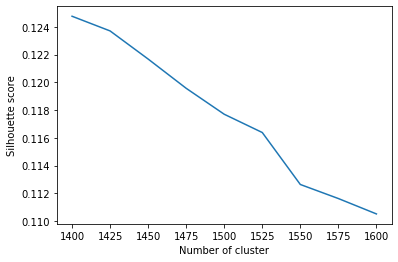

1400
Clusters:  1400
adjusted_rand_score:  0.13789953646573153
adjusted_mutual_info_score:  0.48527404276704245
homogeneity_score:  0.7897299769700769
completeness_score:  0.9999308456775142
v_measure_score:  0.88248605963262
fowlkes_mallows_score:  0.2755413582325003




In [0]:
AgglomerativeClustering_complete(features, labels)

In [0]:
cluster_alg = cluster.AgglomerativeClustering(n_clusters=500, linkage='complete', affinity='cosine')
km_visualize_cluster(cluster_alg, 'AgglomerativeClustering', features, labels, data_type='features')

In [0]:
MeanShift_cluster(features, labels, 10)

In [0]:
cluster_alg = MeanShift(bandwidth=10, bin_seeding=True)
km_visualize_cluster(cluster_alg, 'MeanShift', features, labels, data_type='features')

MiniBatchKMeans
1400
1425
1450
1475
1500
1525
1550
1575
1600


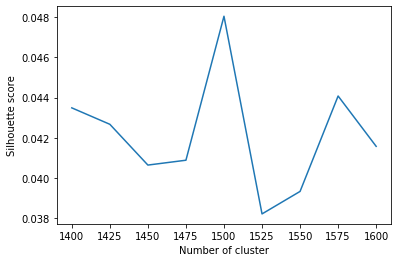

Clusters:  1450
adjusted_rand_score:  0.12918573882550022
adjusted_mutual_info_score:  0.4670033827249295
homogeneity_score:  0.7816044639748769
completeness_score:  0.9833293679516744
v_measure_score:  0.870938739623648
fowlkes_mallows_score:  0.24637999960781132




In [0]:
MiniBatchKMeans_cluster(features, labels)

In [0]:
cluster_alg = cluster.MiniBatchKMeans(n_clusters=200, batch_size=256)
km_visualize_cluster(cluster_alg, 'MiniBatchKMeans', features, labels, data_type='features')

In [0]:
AffinityPropagation_cluster(features, labels)

In [0]:
cluster_alg = cluster.AffinityPropagation(damping=0.5, max_iter=200)
km_visualize_cluster(cluster_alg, 'AffinityPropagation', features, labels, data_type='features')

In [0]:
DBSCAN_cluster(features, labels, 1)

DBSCAN
Clusters:  3739
adjusted_rand_score:  0.0
adjusted_mutual_info_score:  1.202902359249706e-11
homogeneity_score:  0.6517209468303616
completeness_score:  1.0
v_measure_score:  0.789141710748427
fowlkes_mallows_score:  0.0




In [0]:
cluster_alg = cluster.DBSCAN(eps=1,min_samples=1, algorithm='kd_tree')
km_visualize_cluster(cluster_alg, 'DBSCAN', features, labels, data_type='features')

Birch
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


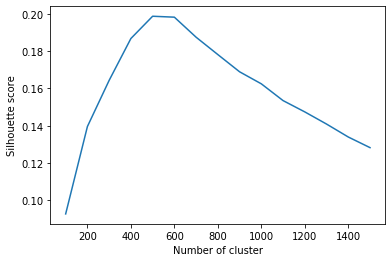

Clusters:  500
adjusted_rand_score:  0.3794580611588036
adjusted_mutual_info_score:  0.8283121341911814
homogeneity_score:  0.9203647954780035
completeness_score:  0.9775315429569219
v_measure_score:  0.9480872062261928
fowlkes_mallows_score:  0.4855393471720077




In [0]:
Birch_cluster(features, labels,)

In [0]:
cluster_alg = cluster.Birch(branching_factor=50, n_clusters=500, threshold=0.5, compute_labels=True)
km_visualize_cluster(cluster_alg, 'Birch', features, labels, data_type='features')

### Clustering methods comparison

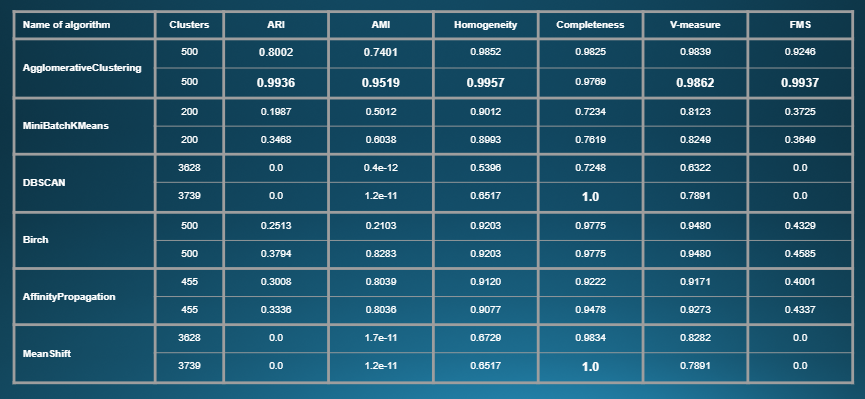